In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, col, monotonically_increasing_id, count

In [9]:
spark = SparkSession.builder.master("local[4]") \
                    .appName('recommendation_system') \
                    .config("spark.driver.memory", "15g") \
                    .getOrCreate()

In [10]:
df = spark.read.options(
            header=True,
            inferSchema=True
        ) \
        .csv('data/ratings_edited.csv')

In [11]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- movieIdx: integer (nullable = true)



In [12]:
df.show()

+------+------+--------+
|userId|rating|movieIdx|
+------+------+--------+
|     0|   3.5|    3903|
|     1|   4.0|    1528|
|     1|   3.0|    3825|
|     2|   4.0|    2281|
|     6|   3.0|    1528|
|     6|   2.0|    3088|
|     8|   2.0|    4424|
|    10|   5.0|    1528|
|    10|   5.0|    1539|
|    13|   5.0|     467|
|    13|   3.5|    1528|
|    13|   4.5|    3088|
|    13|   4.5|   10371|
|    13|   4.0|   10864|
|    15|   4.0|    1528|
|    16|   4.0|    1528|
|    17|   2.5|    1528|
|    20|   3.0|    2780|
|    21|   3.0|    1528|
|    22|   5.0|    1528|
+------+------+--------+
only showing top 20 rows



In [84]:
print(f'The number of rows in the ratings dataframe is {df.count()}')

The number of rows in the ratings dataframe is 20000263


### Distribution of the per user's ratings count

In [14]:
number_of_ratings_per_user = df.groupBy('userId') \
    .agg(count("*").alias("number_of_ratings")) \
    .orderBy(col('number_of_ratings').desc()).toPandas()

In [136]:
print(
    f"The minimum number of per person rating is {number_of_ratings_per_user['number_of_ratings'].min()}\n"
    f"The mean of per person ratings is {number_of_ratings_per_user['number_of_ratings'].mean()}\n"
    f"The maximum number of per person ratings is  {number_of_ratings_per_user['number_of_ratings'].max()}\n"
)

The minimum number of per person rating is 20
The mean of per person ratings is 144.4135299257002
The maximum number of per person ratings is  9254



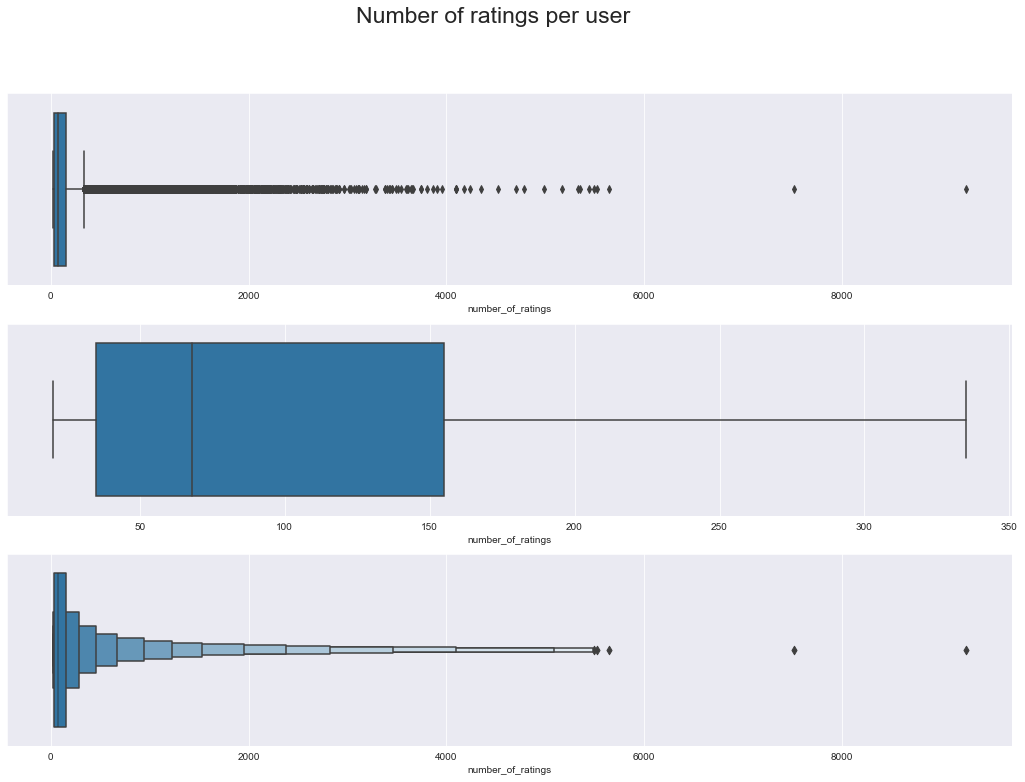

In [115]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

sns.boxplot(data=number_of_ratings_per_user, x='number_of_ratings', ax=axs[0])
sns.boxplot(data=number_of_ratings_per_user, x='number_of_ratings', showfliers=False, ax=axs[1])
sns.boxenplot(data=number_of_ratings_per_user, x='number_of_ratings', ax=axs[2], scale='area')

fig.suptitle('Number of ratings per user', fontsize=23)

plt.show()

<Figure size 1296x648 with 0 Axes>

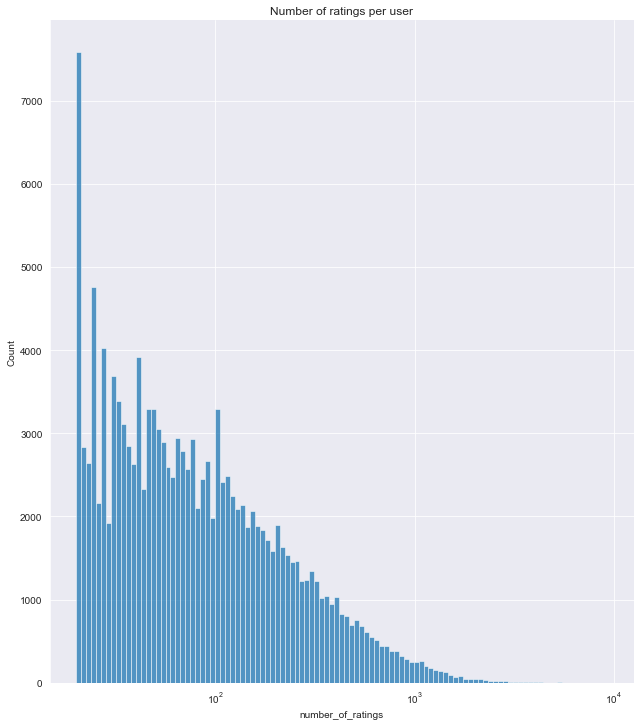

In [117]:
plt.figure(figsize=(18, 9))
sns.displot(data=number_of_ratings_per_user, x='number_of_ratings', log_scale=True, height=10, aspect=.9)
plt.title('Number of ratings per user')
plt.show()

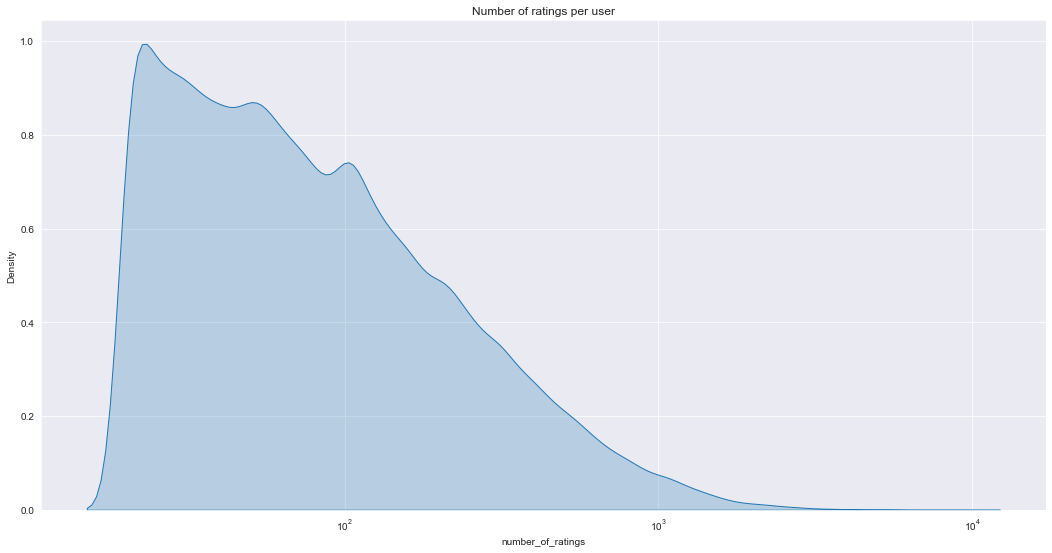

In [118]:
plt.figure(figsize=(18, 9))
sns.kdeplot(data=number_of_ratings_per_user, x="number_of_ratings", log_scale=True, fill=True)
plt.title('Number of ratings per user')
plt.show()

In [165]:
arr = number_of_ratings_per_user['number_of_ratings'].values
print("25th quantile of per person ratings is: ", np.quantile(arr, .25))
print("50th quantile of per person ratings is: ", np.quantile(arr, .50))
print("75th quantile of per person ratings is: ", np.quantile(arr, .75))

25th quantile of per person ratings is:  35.0
50th quantile of per person ratings is:  68.0
75th quantile of per person ratings is:  155.0


Per user ratings count is right skewed. It means only few users have rated more than 100 movies

In [176]:
del number_of_ratings_per_user

### Distribution of the Per movie's ratings count

In [177]:
number_of_ratings_per_movie = df.groupBy('movieIdx') \
    .agg(count("*").alias("number_of_ratings")) \
    .orderBy(col('number_of_ratings').desc()).toPandas()

In [180]:
print(
    f"The minimum number of rating received by a movie is {number_of_ratings_per_movie['number_of_ratings'].min()}\n"
    f"The mean of per movie ratings is {number_of_ratings_per_movie['number_of_ratings'].mean()}\n"
    f"The maximum number of ratings received by a single movie is  {number_of_ratings_per_movie['number_of_ratings'].max()}\n"
)

The minimum number of rating received by a movie is 1
The mean of per movie ratings is 747.8411232425965
The maximum number of ratings received by a single movie is  67310



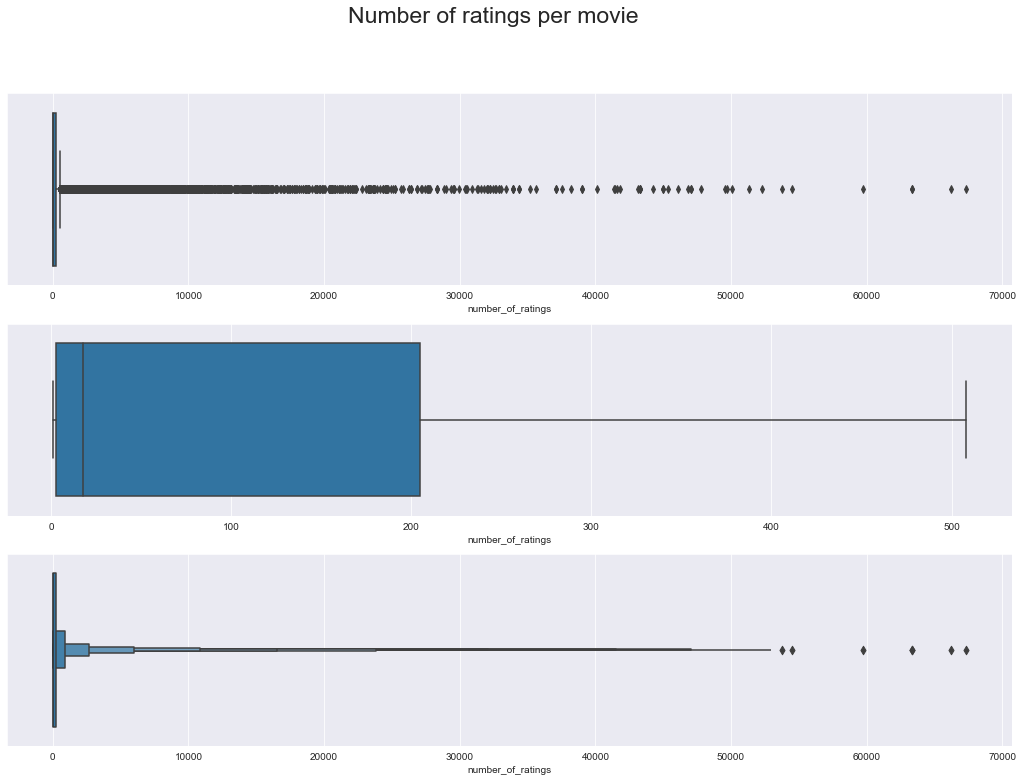

In [181]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

sns.boxplot(data=number_of_ratings_per_movie, x='number_of_ratings', ax=axs[0])
sns.boxplot(data=number_of_ratings_per_movie, x='number_of_ratings', showfliers=False, ax=axs[1])
sns.boxenplot(data=number_of_ratings_per_movie, x='number_of_ratings', ax=axs[2], scale='area')

fig.suptitle('Number of ratings per movie', fontsize=23)

plt.show()

<Figure size 1296x648 with 0 Axes>

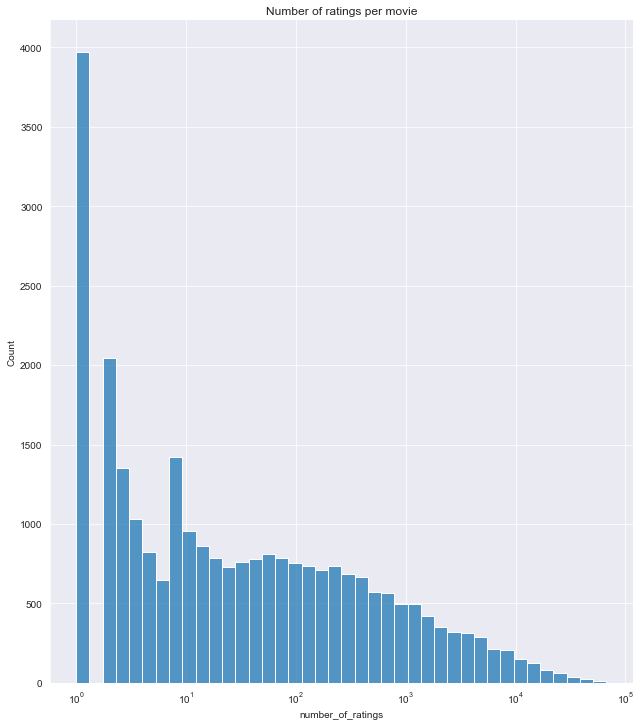

In [182]:
plt.figure(figsize=(18, 9))
sns.displot(data=number_of_ratings_per_movie, x='number_of_ratings', log_scale=True, height=10, aspect=.9)
plt.title('Number of ratings per movie')
plt.show()

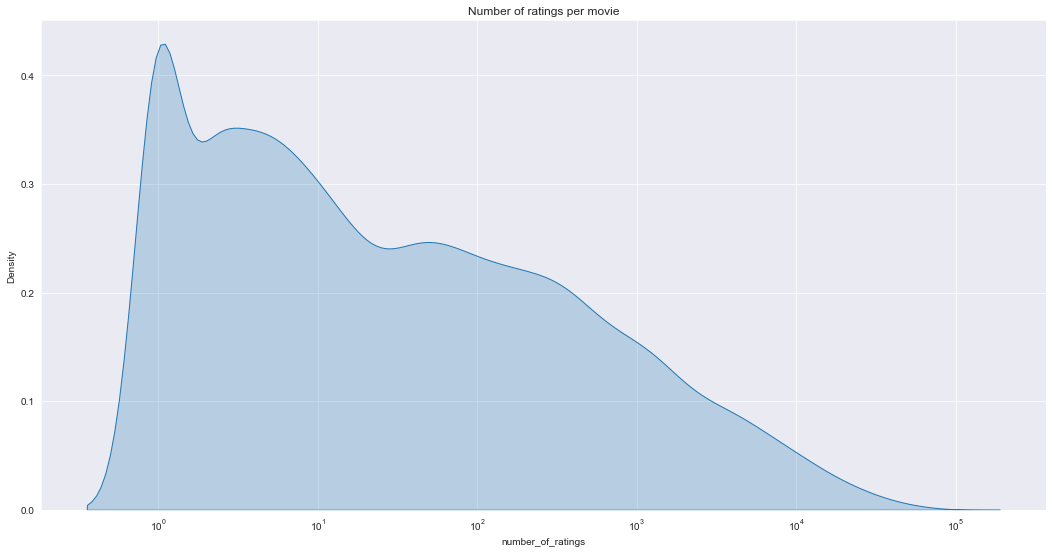

In [183]:
plt.figure(figsize=(18, 9))
sns.kdeplot(data=number_of_ratings_per_movie, x="number_of_ratings", log_scale=True, fill=True)
plt.title('Number of ratings per movie')
plt.show()

In [184]:
arr = number_of_ratings_per_movie['number_of_ratings'].values
print("25th quantile of per movie ratings is: ", np.quantile(arr, .25))
print("50th quantile of per movie ratings is: ", np.quantile(arr, .50))
print("75th quantile of per movie ratings is: ", np.quantile(arr, .75))

25th quantile of per movie ratings is:  3.0
50th quantile of per movie ratings is:  18.0
75th quantile of per movie ratings is:  205.0


Per movie ratings is also right skewed.

It is expected that not all users would rate all the movies and not all the movies would get rated by all the users. Hence in this project, we will use machine learning approach to predict what rating a particular user would give for a particular movie.

In [6]:
spark.stop()